## Read data

Read data and divaded to three part train, valid and test datasets.

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


## Convert images to tensors 

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:03<00:00, 238.61it/s]


# Model Dogs Identification

In [3]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [7]:
def VGG19_model():
    # create the base pre-trained model
    base_model = VGG19(weights='imagenet', include_top=False)
    
    # freeze all the layer in the model
    for layer in base_model.layers:
        layer.trainable = False
        
    # add a global spatial average pooling layer
    x = base_model.output
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer 
    predictions = Dense(len(dog_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    return model

## Create model with Imagenet Wight

In [8]:
from keras.callbacks import ModelCheckpoint  
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_imagenet.hdf5',
                               verbose=1, save_best_only=True)
tensorborad = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, 
            write_images=True, embeddings_freq=0, embeddings_layer_names=None,
            embeddings_metadata=None, embeddings_data=None)
model = VGG19_model()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

## User freezed VGG19 model
This model is just traing the last two Dense, the VGG19 model's layers is freezed. 

In [9]:
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 50

history = model.fit(train_tensors, train_targets,validation_data=(valid_tensors,valid_targets), 
                    epochs=epochs, batch_size=75, callbacks=[checkpointer,tensorborad], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 47s 7ms/step - loss: 4.7593 - val_loss: 4.5696

Epoch 00001: val_loss improved from inf to 4.56957, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/50
6680/6680 [==============================] - 44s 7ms/step - loss: 4.2350 - val_loss: 4.2091

Epoch 00002: val_loss improved from 4.56957 to 4.20911, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/50
6680/6680 [==============================] - 45s 7ms/step - loss: 3.7589 - val_loss: 3.8376

Epoch 00003: val_loss improved from 4.20911 to 3.83763, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/50
6680/6680 [==============================] - 45s 7ms/step - loss: 3.3927 - val_loss: 3.7727

Epoch 00004: val_loss improved from 3.83763 to 3.77269, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/50
6680/6680 [==============================] - 46s 7ms/step - loss: 

6680/6680 [==============================] - 46s 7ms/step - loss: 0.7005 - val_loss: 3.7858

Epoch 00049: val_loss did not improve from 2.75500
Epoch 50/50
6680/6680 [==============================] - 46s 7ms/step - loss: 0.6732 - val_loss: 3.3696

Epoch 00050: val_loss did not improve from 2.75500


## Show the result for after train freezed model

In [10]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

dog_breed_predictions_train=[np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in train_tensors]
# report train accuracy
train_accuracy = 100*np.sum(np.array(dog_breed_predictions_train)==np.argmax(train_targets, axis=1))/len(dog_breed_predictions_train)
print('traning accuracy: %.4f%%' % train_accuracy)

dog_breed_predictions_valid=[np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]
# report valid accuracy
validation_accuracy = 100*np.sum(np.array(dog_breed_predictions_valid)==np.argmax(valid_targets, axis=1))/len(dog_breed_predictions_valid)
print('Validation accuracy: %.4f%%' % train_accuracy)

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

traning accuracy: 62.3952%
Validation accuracy: 62.3952%
Test accuracy: 32.6555%


### Set trainable value
change the trainable value for the first 5 and retrain the other layer.

In [11]:
model = VGG19_model()

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 6 layers and unfreeze the rest:
for layer in model.layers[:6]:
    layer.trainable = False
    
for layer in model.layers[6:]:
    layer.trainable = True


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

In [ ]:
epochs = 1000
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history=model.fit(train_tensors, train_targets,validation_data=(valid_tensors,valid_targets), 
                    epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorborad], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1000
6680/6680 [==============================] - 97s 15ms/step - loss: 15.9220 - val_loss: 15.9637

Epoch 00001: val_loss did not improve from 2.75500
Epoch 2/1000
6680/6680 [==============================] - 99s 15ms/step - loss: 15.9661 - val_loss: 15.9637

Epoch 00002: val_loss did not improve from 2.75500
Epoch 3/1000
6680/6680 [==============================] - 99s 15ms/step - loss: 15.9661 - val_loss: 15.9637

Epoch 00003: val_loss did not improve from 2.75500
Epoch 4/1000
6680/6680 [==============================] - 99s 15ms/step - loss: 15.9661 - val_loss: 15.9637

Epoch 00004: val_loss did not improve from 2.75500
Epoch 5/1000
6680/6680 [==============================] - 99s 15ms/step - loss: 15.9661 - val_loss: 15.9637

Epoch 00005: val_loss did not improve from 2.75500
Epoch 6/1000
6680/6680 [==============================] - 99s 15ms/step - loss: 15.9661 - val_loss: 15.9637

Epoch 00006: val_loss did not improve from 2

dict_keys(['val_loss', 'loss'])


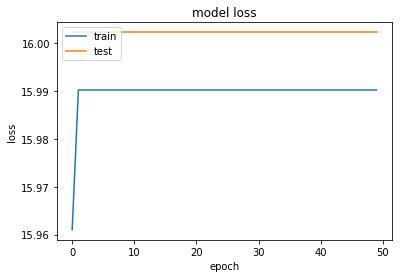

In [13]:
import matplotlib.pyplot as plt                        
%matplotlib inline 

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Training result

In [14]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

dog_breed_predictions_train=[np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in train_tensors]
# report train accuracy
train_accuracy = 100*np.sum(np.array(dog_breed_predictions_train)==np.argmax(train_targets, axis=1))/len(dog_breed_predictions_train)
print('traning accuracy: %.4f%%' % train_accuracy)

dog_breed_predictions_valid=[np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]
# report valid accuracy
validation_accuracy = 100*np.sum(np.array(dog_breed_predictions_valid)==np.argmax(valid_targets, axis=1))/len(dog_breed_predictions_valid)
print('Validation accuracy: %.4f%%' % train_accuracy)

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

traning accuracy: 62.3952%
Validation accuracy: 62.3952%
Test accuracy: 32.6555%
